In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report, silhouette_score
from sklearn.cluster import KMeans

In [2]:
# read the .txt file in
df = pd.read_csv("vertebral_column_data.txt", delim_whitespace = True, header = None)

In [3]:
df.head()

,0,1,2,3,4,5,6
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


In [4]:
# add the column names
df.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope',
'pelvic_radius', 'grade_of_spondylolisthesis', 'class']

In [5]:
# check for null values
df.isna().sum()

pelvic_incidence              0
pelvic_tilt                   0
lumbar_lordosis_angle         0
sacral_slope                  0
pelvic_radius                 0
grade_of_spondylolisthesis    0
class                         0
dtype: int64

In [6]:
# check there are no unusual values in the class column
df['class'].unique()

array(['AB', 'NO'], dtype=object)

In [7]:
df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


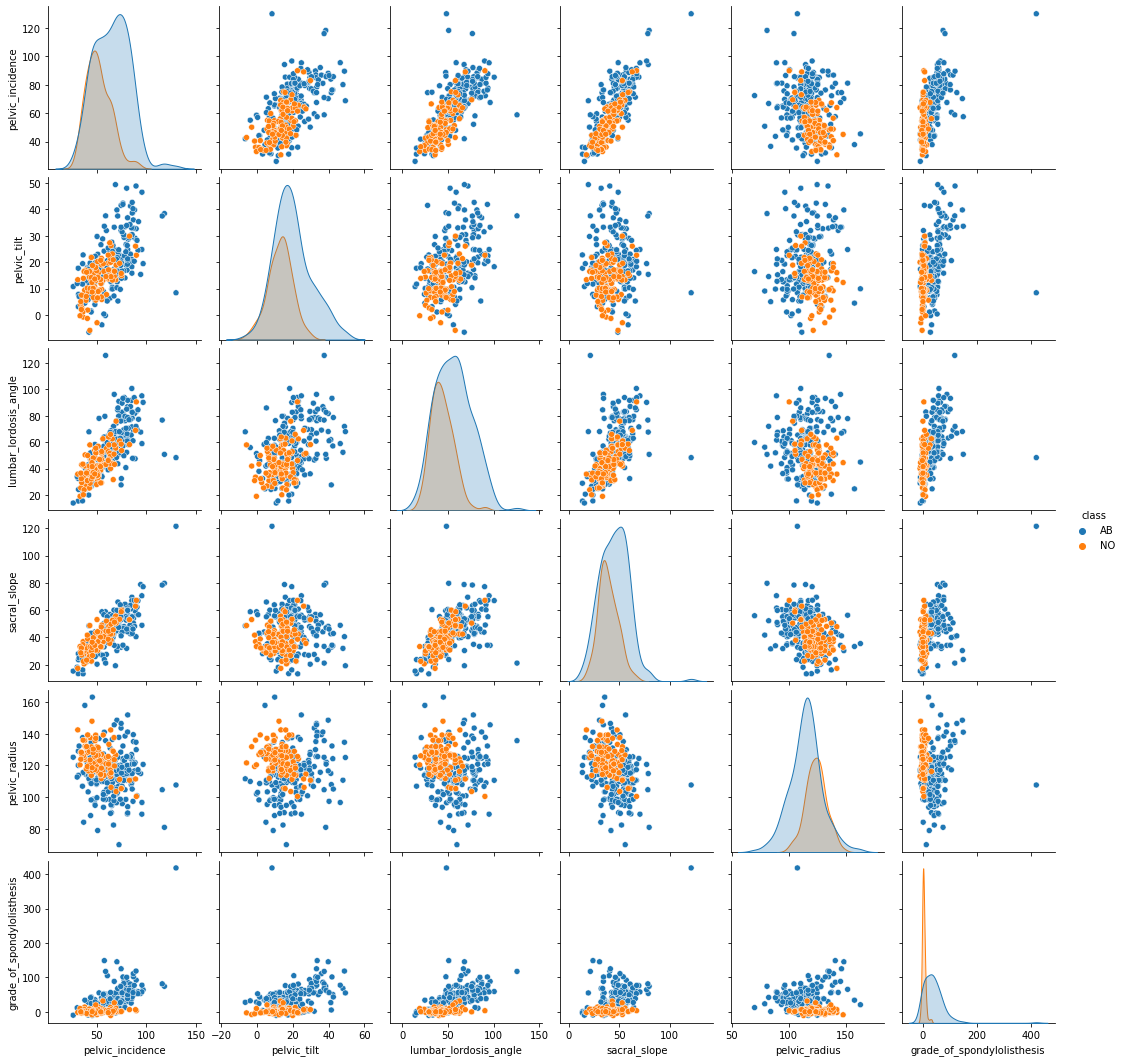

In [8]:
# observe general patterns
sns.pairplot(df, hue = 'class')

<AxesSubplot:xlabel='grade_of_spondylolisthesis', ylabel='lumbar_lordosis_angle'>

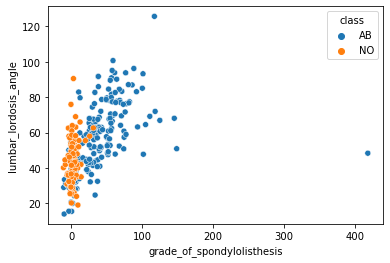

In [9]:
## a close up on plots with outliers
sns.scatterplot(data = df, x = 'grade_of_spondylolisthesis', y = 'lumbar_lordosis_angle', hue = 'class')

In [10]:
# there is a clear outlier which has extremely high grade_of_spondylolisthesis
# another one with extremely high sacral_slope
# another one with high lumbar_lordosis_angle
# check their row indices

grade_of_spondylolisthesis_max = df['grade_of_spondylolisthesis'].max()
index = df[df['grade_of_spondylolisthesis'] == grade_of_spondylolisthesis_max].index[0]
index

115

In [11]:
sacral_slope_max = df['sacral_slope'].max()
index = df[df['sacral_slope'] == sacral_slope_max].index[0]
index

115

In [12]:
lumbar_lordosis_angle_max = df['lumbar_lordosis_angle'].max()
index = df[df['lumbar_lordosis_angle'] == lumbar_lordosis_angle_max].index[0]
index

197

In [13]:
# remove these outliers
indices_to_remove = [115,197]
df.drop(indices_to_remove, inplace = True)

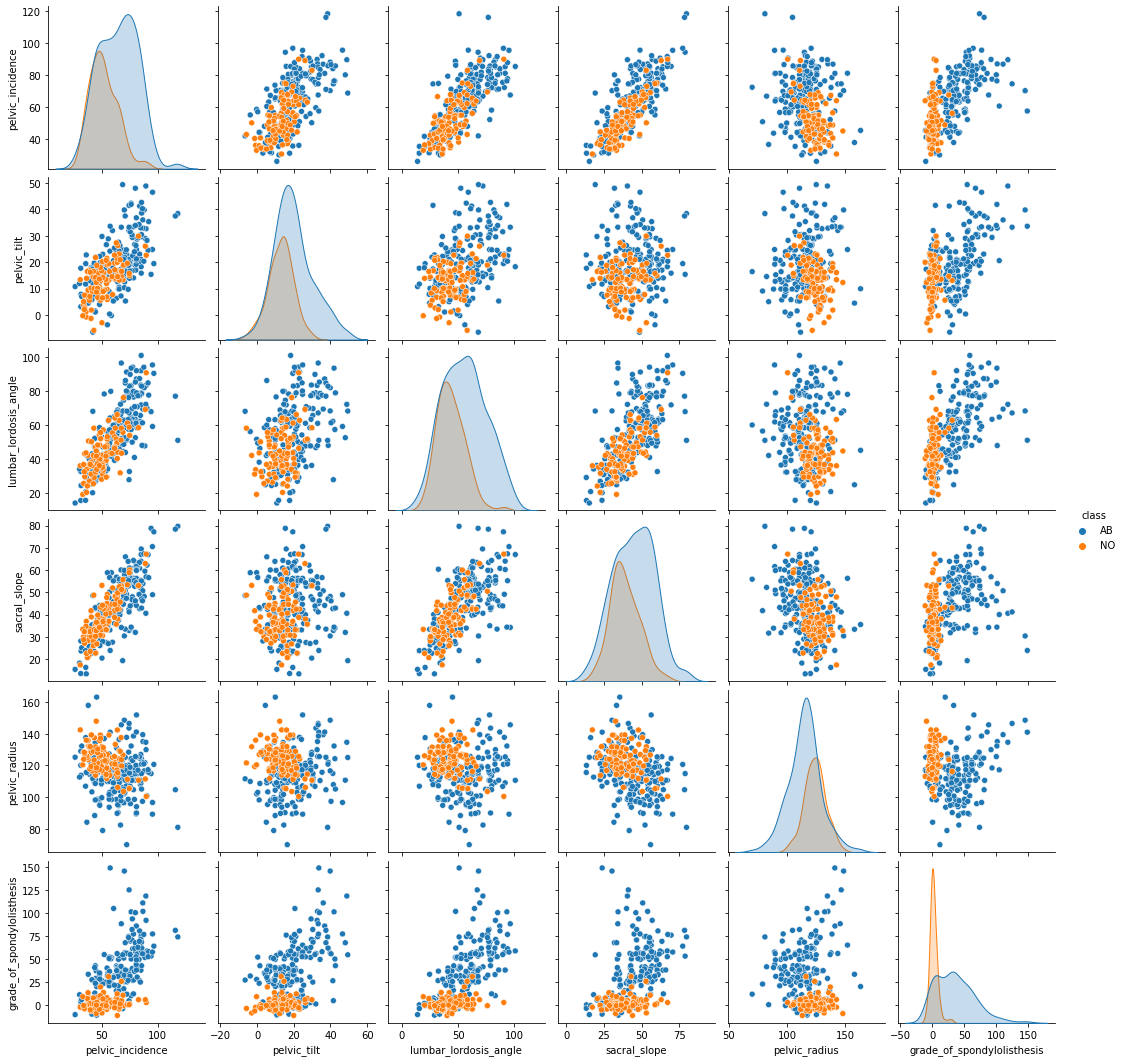

In [14]:
# observe again with outliers removed
sns.pairplot(df, hue = 'class')

In [15]:
# high concentration around 0 for grade_of_spondylolisthesis
# check if there are zero values
(df['grade_of_spondylolisthesis'] == 0).sum()

0

In [16]:
df[df['class'] == 'NO']['grade_of_spondylolisthesis'].mean()

2.187000000000001

There are negative values in the pelvic_tilt column, which upon further research, makes sense.

There should not be negative values in the grade_of_spondylolisthesis column, however. Although these could be removed, since the focus of this coursework is classification algorithms, we will keep this data.

From the pairplots, we can see that the grade_of_spondylolisthesis predictor will be useful in classification. This is because of its large peak around 2.187. Those patients with values around this will likely be classified as 'normal'.

<AxesSubplot:xlabel='grade_of_spondylolisthesis', ylabel='Density'>

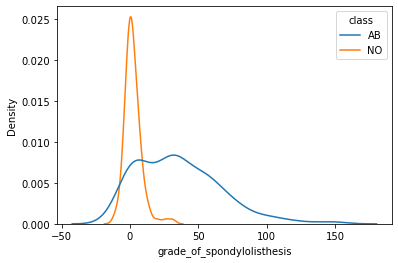

In [17]:
## closer look at grade_of_spondylolisthesis
sns.kdeplot(data = df, x = 'grade_of_spondylolisthesis', hue = 'class')

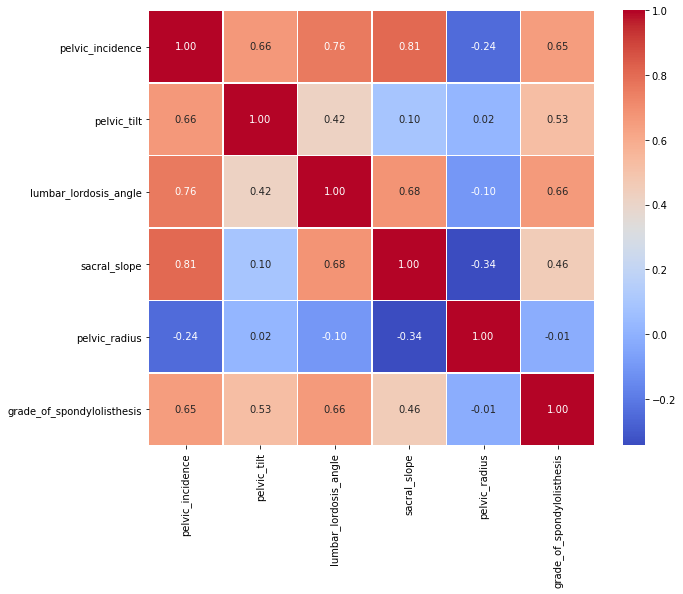

In [18]:
# observe correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

pelvic_incidence has quite high correlations with most of the other variables, particularly sacral_slope and lumbar_lordosis_angle. This may be a candidate for removal.

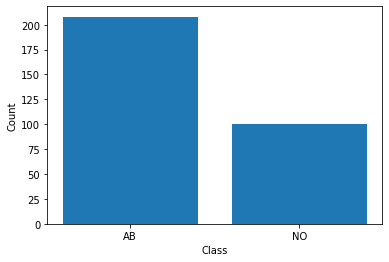

In [19]:
# observe the total number of 'NO' and 'AB' instances
# there is some class imbalance
class_count = df['class'].value_counts()

# plot a bar chart
plt.bar(class_count.index, class_count.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(['NO','AB'])
plt.show()

In [20]:
# convert the 'NO' and 'AB' labels to 0s and 1s
df['class'] = df['class'].map({'AB': 1, 'NO': 0})

In [21]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1


# Classification

## Supervised

### KNN

Average validation accuracy: 0.8979323308270676
Average precision: 0.9747899159663865
Average recall: 0.8169014084507042
Average F1-score: 0.888888888888889
Average confusion matrix:


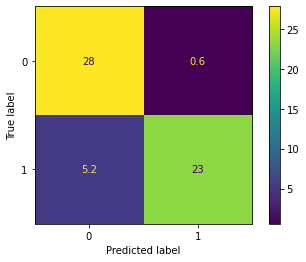

In [22]:
## initial KNN model, using 5 nearest neighbors

# predictors as X
X = df[['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope',
'pelvic_radius', 'grade_of_spondylolisthesis']].values
# target variable as y
y = df[['class']].values

# reshape y
y = np.ravel(y)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# initialise the standard scaler
scaler = StandardScaler()

# apply scaling
# fit on training data only to avoid data leakage
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# initialise the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# initialise K-fold CV object
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

# initialise lists to store evaluation metrics
val_accuracies = []
conf_matrices = []

# apply SMOTE to the training data only
# only applying to the training data avoids data leakage
# addresses class imbalance
smote = SMOTE(random_state = 1)
X_train, y_train = smote.fit_resample(X_train, y_train)

# fit the KNN model
knn.fit(X_train, y_train)

# iterate over the folds
for train_index, val_index in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # predictions on the validation set
    y_pred_val = knn.predict(X_val_fold)

    # accuracy on the validation set
    val_accuracy = accuracy_score(y_val_fold, y_pred_val)
    val_accuracies.append(val_accuracy)

    # confusion matrix
    conf_matrix = confusion_matrix(y_val_fold, y_pred_val)
    conf_matrices.append(conf_matrix)

    
## following metrics are the averages based on the cross-validation process
    
# print average evaluation metrics
print("Average validation accuracy:", np.mean(val_accuracies))

# display the average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_matrix)
disp.plot()

# calculate additional metrics from the average confusion matrix
tn, fp, fn, tp = avg_conf_matrix.ravel()
# precision
precision = tp / (tp + fp)
# recall
recall = tp / (tp + fn)
# F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# display the metrics
print("Average precision:", precision)
print("Average recall:", recall)
print("Average F1-score:", f1_score)
print("Average confusion matrix:")

Average validation accuracy: 0.8978696741854637
Average precision: 0.982905982905983
Average recall: 0.8098591549295775
Average F1-score: 0.8880308880308881
Average confusion matrix:


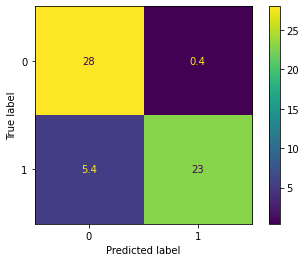

In [23]:
## exactly the same code as above, but with pelvic_incidence removed
# performance improves slightly

# predictors as X
X = df[['pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope',
'pelvic_radius', 'grade_of_spondylolisthesis']].values
# target variable as y
y = df[['class']].values

# reshape y
y = np.ravel(y)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# initialise the standard scaler
scaler = StandardScaler()

# apply scaling
# fit on training data only to avoid data leakage
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# initialise the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# initialise K-fold CV object
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

# initialise lists to store evaluation metrics
val_accuracies = []
conf_matrices = []

# apply SMOTE to the training data only
# only applying to the training data avoids data leakage
# addresses class imbalance
smote = SMOTE(random_state = 1)
X_train, y_train = smote.fit_resample(X_train, y_train)

# fit the KNN model
knn.fit(X_train, y_train)

# iterate over the folds
for train_index, val_index in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # predictions on the validation set
    y_pred_val = knn.predict(X_val_fold)

    # accuracy on the validation set
    val_accuracy = accuracy_score(y_val_fold, y_pred_val)
    val_accuracies.append(val_accuracy)

    # confusion matrix
    conf_matrix = confusion_matrix(y_val_fold, y_pred_val)
    conf_matrices.append(conf_matrix)

    
## following metrics are the averages based on the cross-validation process
    
# print average evaluation metrics
print("Average validation accuracy:", np.mean(val_accuracies))

# display the average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_matrix)
disp.plot()

# calculate additional metrics from the average confusion matrix
tn, fp, fn, tp = avg_conf_matrix.ravel()
# precision
precision = tp / (tp + fp)
# recall
recall = tp / (tp + fn)
# F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# display the metrics
print("Average precision:", precision)
print("Average recall:", recall)
print("Average F1-score:", f1_score)
print("Average confusion matrix:")

In [24]:
## finding the optimal value for k, the number of nearest neighbours
## this is based off of accuracy on the unseen test set


# predictors as X
X = df[['pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope',
        'pelvic_radius', 'grade_of_spondylolisthesis']].values
# target variable as y
y = df[['class']].values

# reshape y
y = np.ravel(y)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# initialise the standard scaler
scaler = StandardScaler()

# apply scaling
# fit on training data only to avoid data leakage
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# initialise K-fold CV object
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# apply SMOTE to the training data only
# only applying to the training data avoids data leakage
# addresses class imbalance
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

from sklearn.model_selection import cross_val_score

# set up an array to keep track of the average cross-validation accuracies of each model we try
cv_accuracies = []
optimal_k = 0
highest_cv_accuracy = 0

# trying different values of k
for k in range(2, 20):
    # initialise KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # compute cross-validation accuracy scores
    cv_scores = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=kfold, scoring='accuracy')
    
    # compute the average cross-validation accuracy
    avg_cv_accuracy = np.mean(cv_scores)
    cv_accuracies.append(avg_cv_accuracy)

    # update the optimal value of k if necessary
    if avg_cv_accuracy > highest_cv_accuracy:
        optimal_k = k
        highest_cv_accuracy = avg_cv_accuracy

# display the optimal k, along with its average cross-validation accuracy score
print("The optimal value of k is", optimal_k, ", which has average cross-validation accuracy score", highest_cv_accuracy)

The optimal value of k is 7 , which has average cross-validation accuracy score 0.8662907268170427


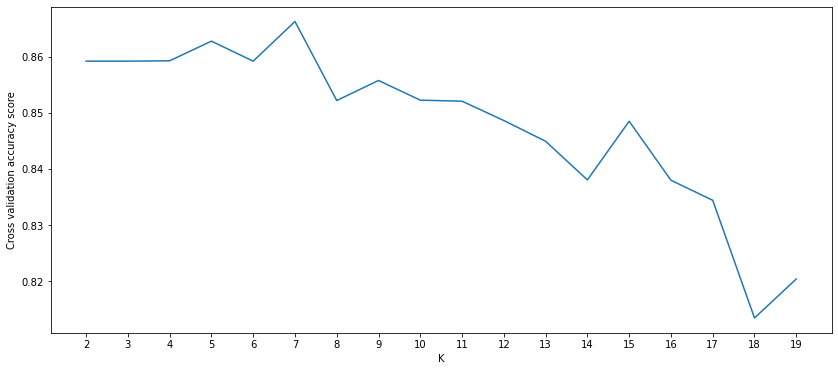

In [25]:
## show the performances of each value of k
plt.figure(figsize = (14,6))
plt.plot(range(2,20), cv_accuracies)
plt.xlabel("K")
plt.ylabel("Cross validation accuracy score")
plt.xticks(range(2,20))
plt.show()

Average validation accuracy: 0.880325814536341
Average precision: 0.9821428571428572
Average recall: 0.7746478873239437
Average F1-score: 0.8661417322834647
Average confusion matrix:


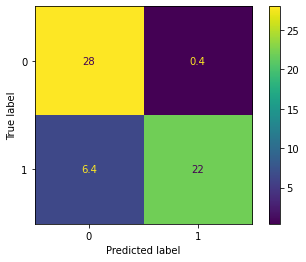

In [26]:
## final KNN model

# predictors as X
X = df[['pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope',
'pelvic_radius', 'grade_of_spondylolisthesis']].values
# target variable as y
y = df[['class']].values

# reshape y
y = np.ravel(y)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# initialise the standard scaler
scaler = StandardScaler()

# apply scaling
# fit on training data only to avoid data leakage
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# initialise the KNN classifier
final_knn = KNeighborsClassifier(n_neighbors=optimal_k)

# initialise K-fold CV object
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

# initialise lists to store evaluation metrics
val_accuracies = []
conf_matrices = []

# apply SMOTE to the training data only
# only applying to the training data avoids data leakage
# addresses class imbalance
smote = SMOTE(random_state = 1)
X_train, y_train = smote.fit_resample(X_train, y_train)

# fit the KNN model
final_knn.fit(X_train, y_train)

# iterate over the folds
for train_index, val_index in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # predictions on the validation set
    y_pred_val = final_knn.predict(X_val_fold)

    # accuracy on the validation set
    val_accuracy = accuracy_score(y_val_fold, y_pred_val)
    val_accuracies.append(val_accuracy)

    # confusion matrix
    conf_matrix = confusion_matrix(y_val_fold, y_pred_val)
    conf_matrices.append(conf_matrix)

    
## following metrics are the averages based on the cross-validation process
    
# print average evaluation metrics
print("Average validation accuracy:", np.mean(val_accuracies))

# display the average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_matrix)
disp.plot()

# calculate additional metrics from the average confusion matrix
tn, fp, fn, tp = avg_conf_matrix.ravel()
# precision
precision = tp / (tp + fp)
# recall
recall = tp / (tp + fn)
# F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# display the metrics
print("Average precision:", precision)
print("Average recall:", recall)
print("Average F1-score:", f1_score)
print("Average confusion matrix:")

Test set accuracy: 0.7526881720430108
Test set precision: 0.9056603773584906
Test set recall: 0.7272727272727273
Test set F1-score: 0.8067226890756303
Test set confusion matrix:


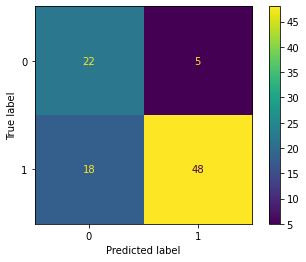

In [27]:
## evaluate performance of this model on the unseen test set

# use the model to predict the unseen labels
y_pred = final_knn.predict(X_test)

# display the test set confusion matrix
test_conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
disp.plot()


# calculate additional metrics from the test set confusion matrix
tn, fp, fn, tp = test_conf_matrix.ravel()
# precision
precision = tp / (tp + fp)
# recall
recall = tp / (tp + fn)
# F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# display the metrics
print("Test set accuracy:", accuracy_score(y_test,y_pred))
print("Test set precision:", precision)
print("Test set recall:", recall)
print("Test set F1-score:", f1_score)
print("Test set confusion matrix:")

## Unsupervised

### Applying PCA

In [28]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1


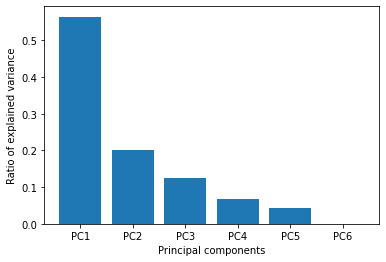

In [29]:
## decide how many components we want

# initialise scaler
scaler = StandardScaler()

# apply the scaler
# drop the class column, we do not want to include it in the PCA
scaled_data = scaler.fit_transform(df.drop(columns = ['class']))

# initialise PCA object
pca = PCA()

# fit to our data
pca_data = pca.fit_transform(scaled_data)

# prepare for elbow plot
per_var = pca.explained_variance_ratio_
labels = ['PC' + str(x) for x in range(1,len(per_var)+1)]

# plot elbow plot
plt.bar(x = range(1,len(per_var)+1), height = per_var, tick_label = labels)
plt.xlabel("Principal components")
plt.ylabel("Ratio of explained variance")
plt.show()

In [30]:
## there is not a very clear elbow in this plot
## we have reduced from 6 features to 5 for certain (PC6 explains virtually no variance)
## but even PC5 explains a non-negligible amount of the variance

## we start by building models using 2, for the sake of visualisations
## later we look at using more, for the sake of  better performance

n_components = 3
reduced_data = pca_data[:, :n_components]
reduced_df = pd.DataFrame(reduced_data, 
                          columns=[f"PC{i}" for i in range(1, n_components + 1)])

# Reassigning index from the original dataframe to the reduced dataframe
reduced_df.index = df.index

# Reattach the 'class' column
reduced_df['class'] = df['class']

In [31]:
reduced_df.head()

,PC1,PC2,PC3,class
0,-0.303390,-0.952249,1.535106,1
1,-2.336257,-0.274624,0.494357,1
2,0.226106,-0.799470,0.859675,1
3,0.361038,-0.716492,1.319662,1
4,-1.446155,-0.979529,0.408064,1


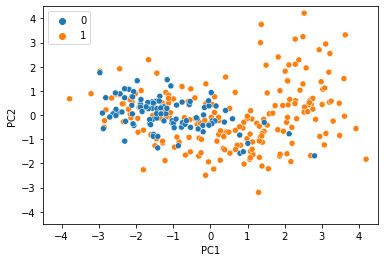

In [32]:
## visualise with the first two principal components only
sns.scatterplot(data = reduced_df, x = 'PC1', y = 'PC2', hue = 'class')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xticks(range(-4,5));
plt.xlim([-4.5, 4.5]);
plt.ylim([-4.5, 4.5]);
plt.legend()
plt.show()

In [33]:
## the above plot reinforces that two principal components does not separate very well

### K Means Clustering

In [34]:
# extract all the samples from the principal component dataframe we just created
samples = reduced_df[['PC1', 'PC2']].values

# save their labels so we can evaluate our unsupervised model later on
# in real scenarios, we often do not have these labels
actual_labels = reduced_df[['class']].values

# although we standardise before PCA, the PCs created are not standardised
# initialise scaler
scaler = StandardScaler()
# fit the scaler
samples = scaler.fit_transform(samples)

# apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
samples, actual_labels = smote.fit_resample(samples, actual_labels)

# iterate over different k
max_k = 10
# save the sums of squares for each model
sum_of_squares = []
# save the silhouette scores for each model
silhouette_scores = []
for k in range(2,max_k+1):
    # initialise KMeans model
    model = KMeans(n_clusters = k, n_init = 10)
    # fit the model
    model.fit(samples)
    # record the sum of squares
    sum_of_squares.append(model.inertia_)
    # calculate the silhouette scores
    silhouette_avg = silhouette_score(samples, model.labels_)
    silhouette_scores.append(silhouette_avg)

C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

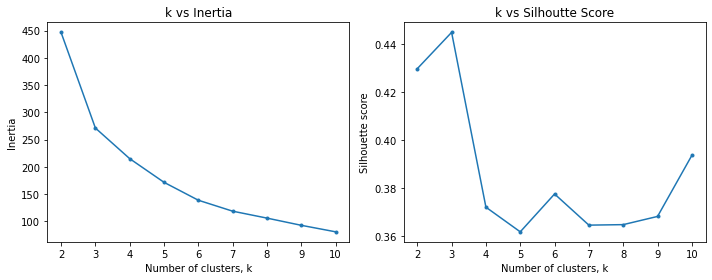

In [35]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# plot elbow plot of inertia for each k
axes[0].plot(list(range(2, max_k + 1)), sum_of_squares, marker=".")
axes[0].set_title("k vs Inertia")
axes[0].set_xlabel("Number of clusters, k")
axes[0].set_ylabel("Inertia")

# plot silhouette scores for each k
axes[1].plot(list(range(2, max_k + 1)), silhouette_scores, marker=".")
axes[1].set_title("k vs Silhoutte Score")
axes[1].set_xlabel("Number of clusters, k")
axes[1].set_ylabel("Silhouette score")

plt.tight_layout()
plt.show()

In [36]:
## build model with k = 2

# initialise model
two_model = KMeans(n_clusters = 2, n_init = 10)
# fit the model
two_model.fit(samples)
# make predictions
two_predicted_labels = two_model.predict(samples)

C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [37]:
## build model with k = 3

# initialise model
three_model = KMeans(n_clusters = 3, n_init = 10)
# fit the model
three_model.fit(samples)
# make predictions
three_predicted_labels = three_model.predict(samples)

C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


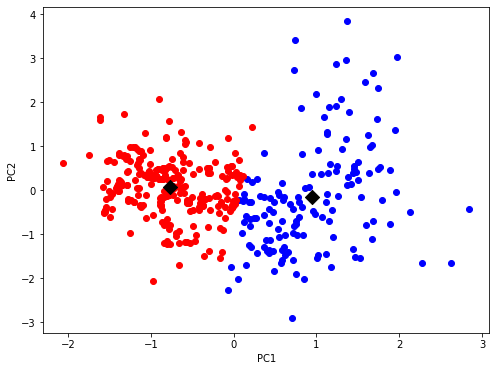

In [38]:
# define colors for each cluster
colors = ['blue', 'red']

# create a scatter plot of the data points
plt.figure(figsize=(8, 6))
for cluster_label in np.unique(two_model.labels_):
    cluster_samples = samples[two_model.labels_ == cluster_label]
    plt.scatter(cluster_samples[:, 0], cluster_samples[:, 1], color=colors[cluster_label], label=f'Cluster {cluster_label}')

# plot centroids
centroids = two_model.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='D', s=100, color='black', label='Centroids')
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

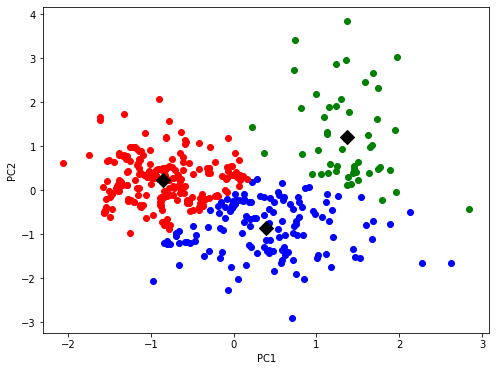

In [39]:
# define colors for each cluster
colors = ['blue', 'red', 'green']

# create a scatter plot of the data points
plt.figure(figsize=(8, 6))
for cluster_label in np.unique(three_model.labels_):
    cluster_samples = samples[three_model.labels_ == cluster_label]
    plt.scatter(cluster_samples[:, 0], cluster_samples[:, 1], color=colors[cluster_label], label=f'Cluster {cluster_label}')
    
# plot centroids
centroids = three_model.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='D', s=100, color='black', label='Centroids')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

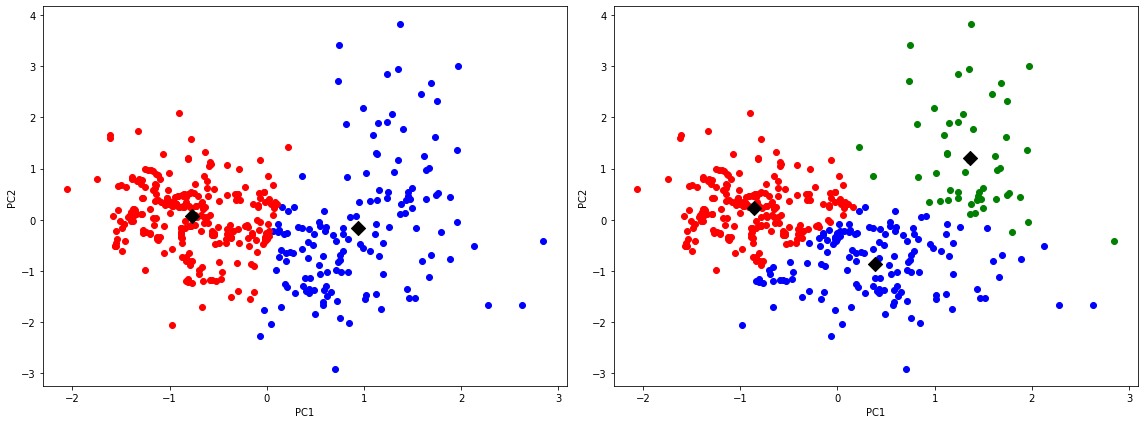

In [40]:
# define colors for each cluster
colors = ['blue', 'red']

# create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# scatter plot for two clusters
for cluster_label in np.unique(two_model.labels_):
    cluster_samples = samples[two_model.labels_ == cluster_label]
    axes[0].scatter(cluster_samples[:, 0], cluster_samples[:, 1], color=colors[cluster_label], label=f'cluster {cluster_label}')

# plot centroids for two clusters
centroids = two_model.cluster_centers_
axes[0].scatter(centroids[:, 0], centroids[:, 1], marker='D', s=100, color='black')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# scatter plot for three clusters
colors = ['blue', 'red', 'green']
for cluster_label in np.unique(three_model.labels_):
    cluster_samples = samples[three_model.labels_ == cluster_label]
    axes[1].scatter(cluster_samples[:, 0], cluster_samples[:, 1], color=colors[cluster_label], label=f'cluster {cluster_label}')

# plot centroids for three clusters
centroids = three_model.cluster_centers_
axes[1].scatter(centroids[:, 0], centroids[:, 1], marker='D', s=100, color='black')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

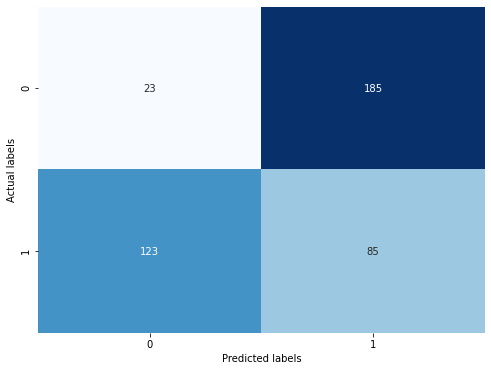

In [41]:
## using the actual labels, for k = 2, we can use a crosstable to evaluate model performance

# reshape predicted labels from (... , ) to (... , 1)
two_predicted_labels = two_predicted_labels.reshape(-1,1)

# create dataframe containing the actual labels and predicted labels
temp_df = pd.DataFrame({'actual_labels':actual_labels.flatten(), 
                        'two_predicted_labels':two_predicted_labels.flatten()})

# form cross-table
two_ct = pd.crosstab(temp_df['actual_labels'], temp_df['two_predicted_labels'])

plt.figure(figsize=(8, 6))
sns.heatmap(two_ct, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [42]:
# extract the TP,FP,TN,FN values from the cross table
TP = two_ct.iloc[1, 1]
FP = two_ct.iloc[0, 1]
TN = two_ct.iloc[0, 0]
FN = two_ct.iloc[1, 0]

# accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# precision
precision = TP / (TP + FP)

# recall
recall = TP / (TP + FN)

# F1-score
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.25961538461538464
Precision: 0.3148148148148148
Recall: 0.40865384615384615
F1-score: 0.3556485355648536


### Improving the K-Means Model

In this following section, we are essentially copy and pasting the above code. The only difference is in increasing from 2 principal components, up to 4. With 4 principal components, however, we cannot make the same visualisations as before.

Increasing to 4 principal components improves performance.

In [43]:
## building a more robust model using more principal components

# extract samples
samples_v2 = reduced_df[['PC1', 'PC2', 'PC3']].values


actual_labels = reduced_df[['class']].values

# initialise scaler
scaler = StandardScaler()
# fit the scaler
samples = scaler.fit_transform(samples)

# apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
samples_v2, actual_labels = smote.fit_resample(samples_v2, actual_labels)

# iterate over different k
max_k = 10
# save the sums of squares for each model
sum_of_squares = []
# save the silhouette scores for each model
silhouette_scores = []
for k in range(2,max_k+1):
    # initialise KMeans model
    model = KMeans(n_clusters = k, n_init = 10)
    # fit the model
    model.fit(samples_v2)
    # record the sum of squares
    sum_of_squares.append(model.inertia_)
    # calculate the silhouette scores
    silhouette_avg = silhouette_score(samples_v2, model.labels_)
    silhouette_scores.append(silhouette_avg)

C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

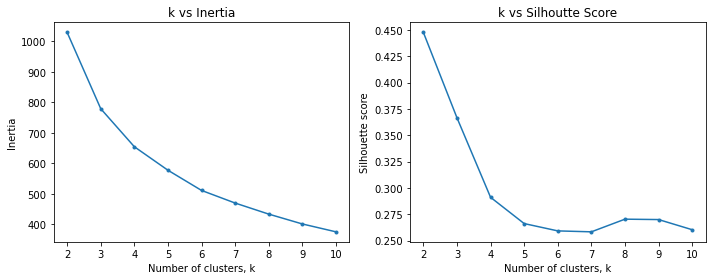

In [44]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# plot elbow plot of inertia for each k
axes[0].plot(list(range(2, max_k + 1)), sum_of_squares, marker=".")
axes[0].set_title("k vs Inertia")
axes[0].set_xlabel("Number of clusters, k")
axes[0].set_ylabel("Inertia")

# plot silhouette scores for each k
axes[1].plot(list(range(2, max_k + 1)), silhouette_scores, marker=".")
axes[1].set_title("k vs Silhoutte Score")
axes[1].set_xlabel("Number of clusters, k")
axes[1].set_ylabel("Silhouette score")

plt.tight_layout()
plt.show()

In [45]:
## build model with k = 2

# initialise model
two_model = KMeans(n_clusters = 2, n_init = 10)
# fit the model
two_model.fit(samples_v2)
# make predictions
two_predicted_labels = two_model.predict(samples_v2)

C:\Users\besso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


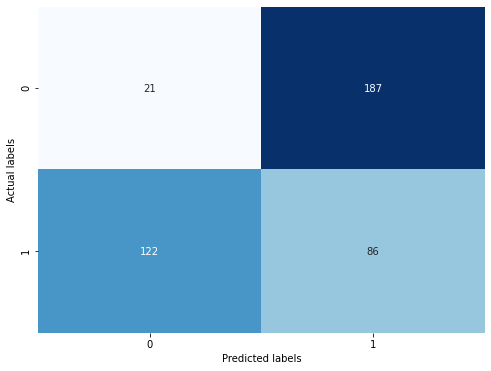

In [46]:
## using the actual labels, for k = 2, we can use a crosstable to evaluate model performance

# reshape predicted labels from (... , ) to (... , 1)
two_predicted_labels = two_predicted_labels.reshape(-1,1)

# k-means clustering assigns 0s and 1s without knowing which is which in reality
# swap the labels round to reflect this
two_predicted_labels = 1 - two_predicted_labels

# create dataframe containing the actual labels and predicted labels
temp_df = pd.DataFrame({'actual_labels':actual_labels.flatten(), 
                        'two_predicted_labels':two_predicted_labels.flatten()})

# form cross-table
two_ct = pd.crosstab(temp_df['actual_labels'], temp_df['two_predicted_labels'])

plt.figure(figsize=(8, 6))
sns.heatmap(two_ct, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [47]:
# extract the TP,FP,TN,FN values from the cross table
TP = two_ct.iloc[1, 1]
FP = two_ct.iloc[0, 1]
TN = two_ct.iloc[0, 0]
FN = two_ct.iloc[1, 0]

# accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# precision
precision = TP / (TP + FP)

# recall
recall = TP / (TP + FN)

# F1-score
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.25721153846153844
Precision: 0.315018315018315
Recall: 0.41346153846153844
F1-score: 0.35758835758835755
